# 1.0 Imported libs

In [ ]:
# Imports
import tensorflow 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import MobileNetV2
from keras.preprocessing import image
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt

# 1.1 Download & Prepare Dataset

In [ ]:
print(pathlib.Path.cwd())
!ls

/content
kaggle.json  seg_pred  seg_train       weights_MLP.h5
sample_data  seg_test  weights_CNN.h5


In [ ]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content"
os.chmod("/content", 600)
os.chmod("/content/kaggle.json", 600)

In [ ]:
#Authenticate and Download Dataset from Kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [ ]:
api.dataset_download_files('puneet6060/intel-image-classification', unzip=True)

# 1.2. Data import infos
Have a first look how many images and classes are in the dataset:
https://www.kaggle.com/puneet6060/intel-image-classification

In [ ]:
train_dir = pathlib.Path('/content/seg_train/seg_train/')     # colab
test_dir = pathlib.Path('/content/seg_test/seg_test/')        # colab

# train_dir = pathlib.Path('/content/intel_image/seg_train/')   # local
# test_dir = pathlib.Path('/content/intel_image/seg_test/')     # local

print(f"We have < {len(list(train_dir.glob('*/*.jpg')))} > images in < TRAIN SET > ({train_dir})")
print(f"We have < {len(list(test_dir.glob('*/*.jpg')))} > images in < TEST SET > ({test_dir})")

We have < 14034 > images in < TRAIN SET > (/content/seg_train/seg_train)
We have < 3000 > images in < TEST SET > (/content/seg_test/seg_test)


In [ ]:
class_names = list([item.name for item in train_dir.glob('*')])
#class_names = list([item.name for item in test_dir.glob('*')])
print("We have the following classes:", class_names)

We have the following classes: ['glacier', 'street', 'buildings', 'forest', 'mountain', 'sea']


# 1.3 Image Data Generator (Keras)

In [ ]:
batch_size = 32

image_generator = ImageDataGenerator(rescale=1./255)

train_generator = image_generator.flow_from_directory(train_dir,
                                                      target_size = (150,150),
                                                      batch_size=batch_size,
                                                      class_mode='categorical')

test_generator = image_generator.flow_from_directory(test_dir,
                                                     target_size=(150,150),
                                                     batch_size=batch_size,
                                                     class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# 1.4 First Data Exploration

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(10):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(np.array(class_names)[label_batch[n]==1][0].title())
        plt.axis('off')

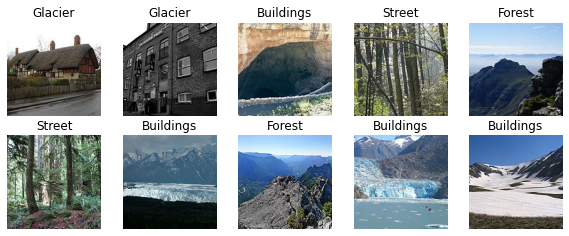

In [ ]:
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch)

# 2.0 First trail with simple Neural Network

In [ ]:
# Parameter
parameter = 'first simple Neural Network'
steps_per_epoch=len(train_generator.filepaths)//batch_size
validation_steps= len(test_generator.filepaths)//batch_size
epochs = 50      # 50
verbose = 1     # 1
print('Parameter -', parameter)
print('steps_per_epoch ', steps_per_epoch)
print('validation_steps ', validation_steps)
print('epochs ', epochs)
print('verbose ', verbose)

Parameter - first simple Neural Network
steps_per_epoch  438
validation_steps  93
epochs  50
verbose  1


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
# Create model adding different layers.
# Using 'softmax' activation because we have a multiclass classification.
model = Sequential([Flatten(),
                    Dense(512, activation = 'relu'),
                    Dense(256, activation = 'relu'),
                    Dropout(rate=0.5),
                    Dense(6, activation = 'softmax')])

# Compile the model
# loss: categorical_crossentropy because the targets are one-hot encoded.
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting the model training with train test and validate test set.
# Callback: early_stopping

trained_MLP = model.fit(train_generator, 
                    validation_data = test_generator,
                    epochs = epochs,
                    verbose = verbose,
                    callbacks= [early_stopping],
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps);

Epoch 1/50
438/438 [==============================] - 19s 43ms/step - loss: 3.2726 - accuracy: 0.2505 - val_loss: 1.6266 - val_accuracy: 0.2184
Epoch 2/50
438/438 [==============================] - 19s 42ms/step - loss: 1.6214 - accuracy: 0.2865 - val_loss: 1.5240 - val_accuracy: 0.3525
Epoch 3/50
438/438 [==============================] - 19s 42ms/step - loss: 1.5797 - accuracy: 0.3122 - val_loss: 1.5604 - val_accuracy: 0.3905
Epoch 4/50
438/438 [==============================] - 18s 41ms/step - loss: 1.5820 - accuracy: 0.3226 - val_loss: 1.5513 - val_accuracy: 0.2379
Epoch 5/50
438/438 [==============================] - 18s 41ms/step - loss: 1.5416 - accuracy: 0.3340 - val_loss: 1.5210 - val_accuracy: 0.3992
Epoch 6/50
438/438 [==============================] - 18s 42ms/step - loss: 1.5877 - accuracy: 0.3301 - val_loss: 1.5239 - val_accuracy: 0.3653
Epoch 7/50
438/438 [==============================] - 18s 41ms/step - loss: 1.5412 - accuracy: 0.3477 - val_loss: 1.4364 - val_accuracy:

In [ ]:
# Save weights
model.save_weights('weights_MLP.h5')

In [ ]:
def plot_acc_loss(trained):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(trained.epoch, trained.history["loss"], label="Train loss")
    ax[0].plot(trained.epoch, trained.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(trained.epoch, trained.history["accuracy"], label="Train acc")
    ax[1].plot(trained.epoch, trained.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

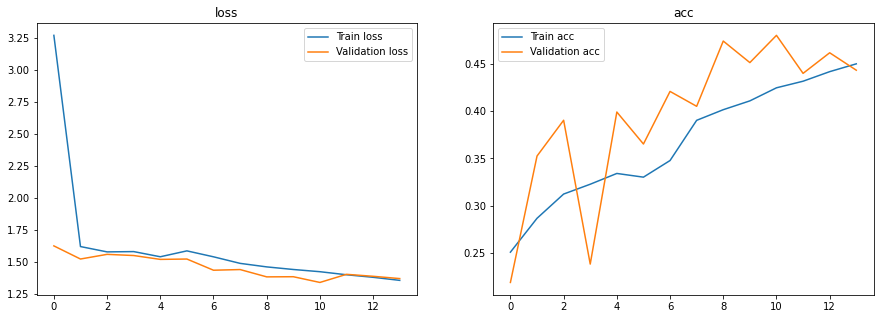

In [ ]:
plot_acc_loss(trained_MLP)

In [ ]:
#Loading weights
model.load_weights('weights_MLP.h5')

# Evaluate the model with the test set.
model_MLP_score = model.evaluate(test_generator, steps=validation_steps)
print("Model MLP Test Loss:", model_MLP_score[0])
print("Model MLP Test Accuracy:", model_MLP_score[1])

93/93 [==============================] - 3s 33ms/step - loss: 1.3715 - accuracy: 0.4432
Model MLP Test Loss: 1.371539831161499
Model MLP Test Accuracy: 0.4432123601436615


# 3.0 CNN Model

In [ ]:
# Parameter
parameter = 'CNN Model'
steps_per_epoch=len(train_generator.filepaths)//batch_size
validation_steps= len(test_generator.filepaths)//batch_size
epochs = 40      # 40
verbose = 1     # 1
print('Parameter -', parameter)
print('steps_per_epoch', steps_per_epoch)
print('validation_steps', validation_steps)
print('epochs', epochs)
print('verbose ', verbose)

Parameter - CNN Model
steps_per_epoch 438
validation_steps 93
epochs 40
verbose  1


In [ ]:
# Create the model adding Conv2D. 
model = Sequential([Conv2D(200, (3,3), activation='relu', input_shape=(150, 150, 3)),
                    MaxPool2D(5,5),
                    Conv2D(180, (3,3), activation='relu'),
                    MaxPool2D(5,5),
                    Flatten(),
                    Dense(180, activation='relu'),
                    Dropout(rate=0.5),
                    Dense(6, activation='softmax')])

# Compile model.
# Loss categorical_crossentropy: targets are one-hot encoded.
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting the model training with train test and validate test set.
# Callback: early_stopping
trained_CNN = model.fit(train_generator,
                    validation_data = test_generator,
                    epochs = epochs,
                    verbose = 1,
                    callbacks= [early_stopping],
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps);

# Save weights
model.save_weights('weights_CNN.h5')

Epoch 1/40
438/438 [==============================] - 23s 52ms/step - loss: 1.0624 - accuracy: 0.5789 - val_loss: 0.7477 - val_accuracy: 0.7238
Epoch 2/40
438/438 [==============================] - 22s 51ms/step - loss: 0.7459 - accuracy: 0.7288 - val_loss: 0.6817 - val_accuracy: 0.7550
Epoch 3/40
438/438 [==============================] - 22s 51ms/step - loss: 0.6344 - accuracy: 0.7755 - val_loss: 0.5449 - val_accuracy: 0.8011
Epoch 4/40
438/438 [==============================] - 23s 52ms/step - loss: 0.5588 - accuracy: 0.8022 - val_loss: 0.5393 - val_accuracy: 0.8118
Epoch 5/40
438/438 [==============================] - 22s 51ms/step - loss: 0.4981 - accuracy: 0.8247 - val_loss: 0.4797 - val_accuracy: 0.8337
Epoch 6/40
438/438 [==============================] - 22s 51ms/step - loss: 0.4639 - accuracy: 0.8365 - val_loss: 0.4502 - val_accuracy: 0.8451
Epoch 7/40
438/438 [==============================] - 22s 51ms/step - loss: 0.4389 - accuracy: 0.8445 - val_loss: 0.5026 - val_accuracy:

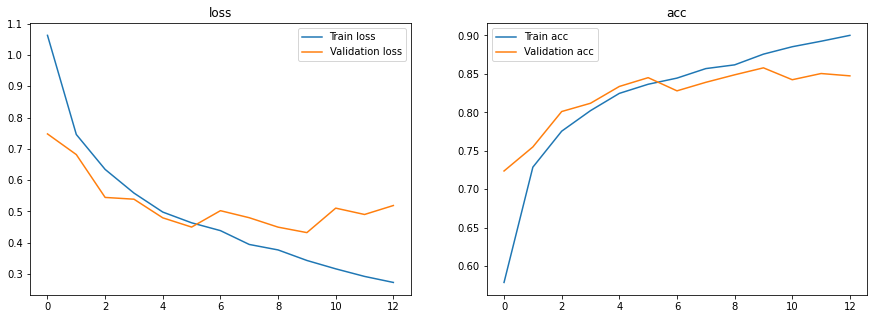

In [ ]:
plot_acc_loss(trained_CNN)

In [ ]:
# Load weights and evaluate model
model.load_weights('weights_CNN.h5')
model_CNN_score = model.evaluate(test_generator)
print("Model CNN Test Loss:", model_CNN_score[0])
print("Model CNN Test Accuracy:", model_CNN_score[1])

94/94 [==============================] - 4s 37ms/step - loss: 0.5192 - accuracy: 0.8470
Model CNN Test Loss: 0.5191602110862732
Model CNN Test Accuracy: 0.847000002861023


# 6.0 Apply Data Augmentation
A brief explication of used parameter:

* **Shear_range:** for randomly applying shearing transformations.
* **Zoom_range:** for randomly zooming inside pictures.
* **Horizontal_flip:** for randomly flipping half of the images horizontally.



In [ ]:
# Parameter
parameter = 'Data Augmentation'
steps_per_epoch=len(train_generator.filepaths)//batch_size
validation_steps= len(test_generator.filepaths)//batch_size
epochs = 40      # 40
verbose = 1     # 1
print('Parameter -', parameter)
print('steps_per_epoch', steps_per_epoch)
print('validation_steps', validation_steps)
print('epochs', epochs)
print('verbose ', verbose)

Parameter - Data Augmentation
steps_per_epoch 438
validation_steps 93
epochs 40
verbose  1


In [ ]:
# Create ImageDataGenerator with new parameters for Data Augmentation
image_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,  
    zoom_range=0.2,        
    horizontal_flip=True,
    validation_split=0.3)

In [ ]:
train_generator = image_generator.flow_from_directory(train_dir,
                                                      target_size = (150,150),
                                                      batch_size=32,
                                                      shuffle=True,
                                                      seed=10,
                                                      class_mode='categorical')

test_generator = image_generator.flow_from_directory(test_dir,
                                                     target_size=(150,150),
                                                     batch_size=32,
                                                     shuffle=True,
                                                     seed=10,
                                                     class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
# Create the same model as the previous one
model = Sequential([Conv2D(200, (3,3), activation='relu', input_shape=(150, 150, 3)),
                    MaxPool2D(5,5),
                    Conv2D(180, (3,3), activation='relu'),
                    MaxPool2D(5,5),
                    Flatten(),
                    Dense(180, activation='relu'),
                    Dropout(rate=0.5),
                    Dense(6, activation='softmax')])

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting the model training with train test and validate test set.
# Callback: early_stopping
trained_DA = model.fit(train_generator,
                    validation_data  = test_generator,
                    epochs = epochs,
                    verbose = verbose,
                    callbacks= [early_stopping])

# Save weights
model.save_weights('weights_CNN_DA.h5')

Epoch 1/40
439/439 [==============================] - 94s 214ms/step - loss: 1.0815 - accuracy: 0.5713 - val_loss: 0.7993 - val_accuracy: 0.7160
Epoch 2/40
439/439 [==============================] - 94s 214ms/step - loss: 0.8175 - accuracy: 0.7027 - val_loss: 0.7081 - val_accuracy: 0.7433
Epoch 3/40
439/439 [==============================] - 95s 217ms/step - loss: 0.7162 - accuracy: 0.7443 - val_loss: 0.5860 - val_accuracy: 0.7933
Epoch 4/40
439/439 [==============================] - 95s 216ms/step - loss: 0.6368 - accuracy: 0.7770 - val_loss: 0.5717 - val_accuracy: 0.8040
Epoch 5/40
439/439 [==============================] - 95s 216ms/step - loss: 0.5959 - accuracy: 0.7910 - val_loss: 0.5266 - val_accuracy: 0.8220
Epoch 6/40
439/439 [==============================] - 94s 215ms/step - loss: 0.5616 - accuracy: 0.8040 - val_loss: 0.4762 - val_accuracy: 0.8377
Epoch 7/40
439/439 [==============================] - 95s 216ms/step - loss: 0.5364 - accuracy: 0.8146 - val_loss: 0.4743 - val_ac

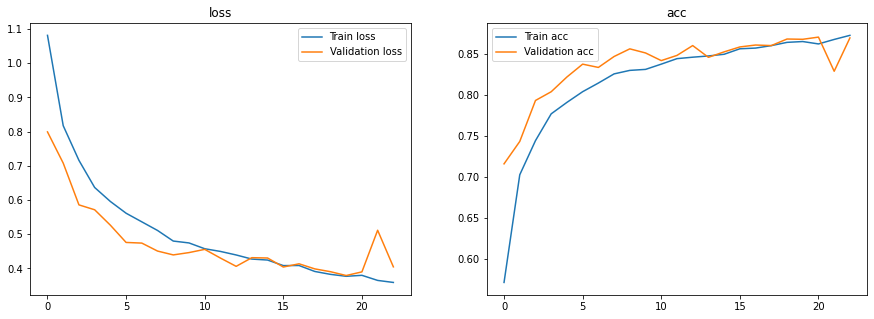

In [ ]:
plot_acc_loss(trained_DA)

In [ ]:
# Load weights and evaluate model
model.load_weights('weights_CNN_DA.h5')
model_DA_score = model.evaluate(test_generator)
print("Model with Data Augmentation Test Loss:", model_DA_score[0])
print("Model with Data Augmentation Test Accuracy:", model_DA_score[1])

94/94 [==============================] - 15s 165ms/step - loss: 0.4044 - accuracy: 0.8693
Model with Data Augmentation Test Loss: 0.40435248613357544
Model with Data Augmentation Test Accuracy: 0.8693333268165588


# 7.0 Fine tuning
fist warm up trails

In [ ]:
mobile_model = MobileNetV2(input_shape=(150, 150,3), include_top=False, weights='imagenet')

mobile_model.trainable = True

print("Number of layers in the MobileNetV2 model: ", len(mobile_model.layers))

9412608/9406464 [==============================] - 0s 0us/step
Number of layers in the MobileNetV2 model:  155


In [ ]:
fine_tune_at = 100
for layer in mobile_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [ ]:
# Create model adding the pre-trained model mobileNetV2, 
# adding GlobalAveragePooling2D layer
model = Sequential([mobile_model,
                    GlobalAveragePooling2D(),
                    Dropout(rate=0.5),
                    Dense(6, activation='softmax')])

model.compile(optimizer= RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 1,870,278
Non-trainable params: 395,392
_________________________________________________________________


In [ ]:
# Fitting model and save weights
trained_FT = model.fit(train_generator,
                    epochs=20,
                    validation_data=test_generator,
                    callbacks=[early_stopping])

model.save_weights('weights_FT.h5')

Epoch 1/20
439/439 [==============================] - 95s 217ms/step - loss: 0.8408 - accuracy: 0.6917 - val_loss: 0.5987 - val_accuracy: 0.7887
Epoch 2/20
439/439 [==============================] - 94s 213ms/step - loss: 0.4206 - accuracy: 0.8548 - val_loss: 0.4011 - val_accuracy: 0.8677
Epoch 3/20
439/439 [==============================] - 94s 214ms/step - loss: 0.3418 - accuracy: 0.8819 - val_loss: 0.3528 - val_accuracy: 0.8820
Epoch 4/20
439/439 [==============================] - 94s 214ms/step - loss: 0.2964 - accuracy: 0.8942 - val_loss: 0.2790 - val_accuracy: 0.9023
Epoch 5/20
439/439 [==============================] - 94s 214ms/step - loss: 0.2701 - accuracy: 0.9060 - val_loss: 0.2617 - val_accuracy: 0.9137
Epoch 6/20
439/439 [==============================] - 94s 214ms/step - loss: 0.2514 - accuracy: 0.9093 - val_loss: 0.2552 - val_accuracy: 0.9133
Epoch 7/20
439/439 [==============================] - 93s 213ms/step - loss: 0.2317 - accuracy: 0.9178 - val_loss: 0.2355 - val_ac

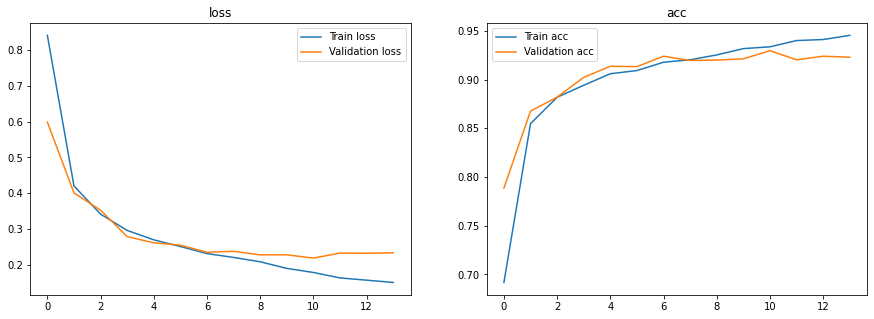

In [ ]:
plot_acc_loss(trained_FT)

In [ ]:
model.load_weights('weights_FT.h5')
model_FT_score = model.evaluate(test_generator)
print("Model Fine Tuning Test Loss:", model_FT_score[0])
print("Model Fine Tuning Test Accuracy:", model_FT_score[1])

94/94 [==============================] - 16s 173ms/step - loss: 0.2416 - accuracy: 0.9247
Model Fine Tuning Test Loss: 0.24158638715744019
Model Fine Tuning Test Accuracy: 0.9246666431427002


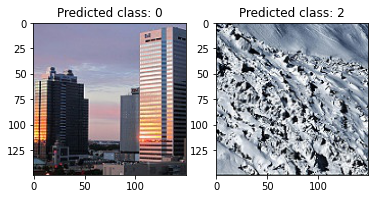

In [ ]:
img1 = image.load_img('/content/seg_pred/seg_pred/5.jpg', target_size=(150, 150))
x = image.img_to_array(img1)
x = np.expand_dims(x, axis=0)
prediction1 = model.predict(x, batch_size=10)

img2 = image.load_img('/content/seg_pred/seg_pred/176.jpg', target_size=(150, 150))
y = image.img_to_array(img2)
y = np.expand_dims(y, axis=0)
prediction2 = model.predict(y, batch_size=10)

plt.figure()
plt.subplot(121)
plt.title("Predicted class: " + str(np.argmax(prediction1[0])))
plt.imshow(img1)
plt.subplot(122)
plt.title("Predicted class: " + str(np.argmax(prediction2[0])))
plt.imshow(img2)

# 8.0 Conclusions of baseline evaluation

First results, notes, next steps


## CNN Model --> 84.7 %

* With standard CNN tools, it seems that the accuracy does not improve as much but reduces overfitting.
* With a CNN we already get a quit good result, with 84% accuracy in the test set.



In [ ]:
print("Model CNN Test Loss:", model_CNN_score[0])
print("Model CNN Test Accuracy:", model_CNN_score[1])

Model CNN Test Loss: 0.5191602110862732
Model CNN Test Accuracy: 0.847000002861023


## Augmentation (general) --> 86.9%

In [ ]:
print("Model with Data Augmentation Test Loss:", model_DA_score[0])
print("Model with Data Augmentation Test Accuracy:", model_DA_score[1])

Model with Data Augmentation Test Loss: 0.40435248613357544
Model with Data Augmentation Test Accuracy: 0.8693333268165588


## Fine Tuning (general) --> 92% acc

In [ ]:
print("Model Fine Tuning Test Loss:", model_FT_score[0])
print("Model Fine Tuning Test Accuracy:", model_FT_score[1])

Model Fine Tuning Test Loss: 0.24158638715744019
Model Fine Tuning Test Accuracy: 0.9246666431427002


## Further improvements steps:

by additonal fine-tuning and/or additional data preproxessing to be evaluated:

* ...
* ...


In [ ]:
pred_dir = pathlib.Path('/content/seg_pred/seg_pred/')          # colab

print(f"We have < {len(list(train_dir.glob('*/*.jpg')))} > images in < TRAIN SET > ({train_dir})")
print(f"We have <  {len(list(test_dir.glob('*/*.jpg')))} > images in < TEST  SET > ({test_dir})")
print(f"We have <  {len(list(test_dir.glob('*/*.jpg')))} > images in < PRED  SET > ({pred_dir})")

We have < 14034 > images in < TRAIN SET > (/content/seg_train/seg_train)
We have <  3000 > images in < TEST  SET > (/content/seg_test/seg_test)
We have <  3000 > images in < PRED  SET > (/content/seg_pred/seg_pred)


## Save Evaluation Data

In [ ]:
!zip results.zip *.*

  adding: kaggle.json (stored 0%)
  adding: weights_CNN_DA.h5 (deflated 7%)
  adding: weights_CNN.h5 (deflated 8%)
  adding: weights_FT.h5 (deflated 9%)
  adding: weights_MLP.h5 (deflated 8%)


In [ ]:
!zip -r /content/seg_pred.zip /content/seg_pred/seg_pred
!zip -r /content/seg_test.zip /content/seg_test/seg_test
!zip -r /content/seg_train.zip /content/seg_train/seg_train

In [ ]:
!ls

kaggle.json  seg_pred	   seg_test.zip   weights_CNN_DA.h5  weights_MLP.h5
results.zip  seg_pred.zip  seg_train	  weights_CNN.h5
sample_data  seg_test	   seg_train.zip  weights_FT.h5
